In [33]:
import logging
logging.getLogger("hmmlearn").setLevel("CRITICAL")

import seaborn as sns
import numpy as np
import pandas as pd
import pyvinecopulib as pv
import scipy
import seaborn as sns
from scipy.stats import nct, laplace_asymmetric ,genhyperbolic, laplace , t
import pandas_ta as ta
import matplotlib.pyplot as plt
from hmmlearn import hmm
pd.plotting.register_matplotlib_converters()

from app.historical_price import HistoricalPrice
from app.random_variable import RandomVariable
from typing import List

import plotly.graph_objects as go
import plotly.subplots as sp

In [34]:
hp = HistoricalPrice()


## CANDIATES: MSN, VNM, MIG, LIX, DHG 
asset = 'DRH'
file = f"data/{asset}_historical_price.csv"
df = hp.read(file)
df.index = pd.DatetimeIndex(df.index).to_period('D')
df.head()

,adj_close,close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,open,high,low,volume
date,,,,,,,,,,
2010-07-26,10.60,18.7,527880,10115450000,0,0,19.7,19.7,18.0,527880
2010-07-27,10.72,18.9,215010,4010777000,0,0,18.9,18.9,17.8,215010
2010-07-28,11.06,19.5,204360,3862798000,0,0,18.2,19.5,18.2,204360
2010-07-29,10.60,18.7,218080,4136933000,0,0,19.5,19.5,18.7,218080
2010-07-30,10.89,19.2,186020,3503319000,0,0,18.6,19.2,17.8,186020


In [35]:
help(ta.wma)

Help on function wma in module pandas_ta.overlap.wma:

wma(close, length=None, asc=None, talib=None, offset=None, **kwargs)
    Weighted Moving Average (WMA)
    
    The Weighted Moving Average where the weights are linearly increasing and
    the most recent data has the heaviest weight.
    
    Sources:
        https://en.wikipedia.org/wiki/Moving_average#Weighted_moving_average
    
    Calculation:
        Default Inputs:
            length=10, asc=True
        total_weight = 0.5 * length * (length + 1)
        weights_ = [1, 2, ..., length + 1]  # Ascending
        weights = weights if asc else weights[::-1]
    
        def linear_weights(w):
            def _compute(x):
                return (w * x).sum() / total_weight
            return _compute
    
        WMA = close.rolling(length)_.apply(linear_weights(weights), raw=True)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 10
        asc (bool): Recent values weigh m

In [40]:
class GMMHMM:
    def set_column_features(self, df: pd.DataFrame):
        self.cols = [i for i in df.columns if 'direction' in i]
    
    def execute(self,df: pd.DataFrame, lags: List[int]) -> pd.DataFrame:
        """
            USE GMMHMM to cluster states based on directional change.
        """
        for lag in lags:
            df = self.get_direction(df,lag)
            
        self.set_column_features(df)
        model = self.get_best_model(df)
        df['states'] = model.predict(df.loc[:,self.cols])
        df = self.post_processing(df)
        return df
    
    def post_processing(self, df: pd.DataFrame) -> pd.DataFrame:
        """
            Create two columns, one for each state. y
        """
        states = pd.get_dummies(df['states'])
        states.columns = ['state_0','state_1']
        states_onehot = df['close'].multiply(states.T).T
        states_onehot[states_onehot==0] = np.nan
        df = pd.concat([df, states_onehot],axis=1)
        df.index = df.index.to_timestamp()
        return df
        
    def get_direction(self, df: pd.DataFrame,lag: int) -> pd.DataFrame:
        """
            Get weighted moving average of the last 'lag' points.
            Obtain lagged returns and directional change.
        """
        df[f'ma_{lag}'] = df.ta.wma(lag)
        df[f'returns_{lag}'] = (df['close']/df[f'ma_{lag}'].shift(lag)-1)
        df[f'directional_change_{lag}'] =  df[f'returns_{lag}']/np.abs(df[f'returns_{lag}'])
        return df.fillna(method='bfill').dropna()
    
    def get_best_model(self,df: pd.DataFrame):
        """
            Fit GMMHMM 10000 times and pick the best model.
            (minimize randomness) 
        """
        best_mle = -100000
        best_model = None
        for i in range(100):
            try:
                model = hmm.GMMHMM(n_components=2,n_iter=10000)
                model.fit(df.loc[:,self.cols])
                mle = model.score(df.loc[:,self.cols])
                if mle>best_mle:
                    best_mle = mle
                    best_model = model
            except Exception:
                continue
        return best_model
    
    def plot_cluster(self,df: pd.DataFrame) -> None:
        fig = go.Figure()
        fig = sp.make_subplots(specs=[[{'secondary_y': True}]])
        fig.add_trace(go.Scatter(x=df.index, y=df['state_0'], mode='markers',marker=dict(color='blue')))
        fig.add_trace(go.Scatter(x=df.index, y=df['state_1'], mode='markers',marker=dict(color='red')))
        fig.update_layout(xaxis_title='Date',
                          yaxis_title='Closing Prices',
                          height=750,
                          width=1250,
                         )
        fig.show()        

In [41]:
rc = GMMHMM()
clustered_df = rc.execute(df,lags=[3])
clustered_df.head()

,adj_close,close,order_matching_volume,order_matching_value,order_negotiated_volume,order_negotiated_value,open,high,low,volume,ma_3,returns_3,directional_change_3,states,state_0,state_1
date,,,,,,,,,,,,,,,,
2010-07-26,10.60,18.7,527880,10115450000,0,0,19.7,19.7,18.0,527880,19.166667,0.001739,1.0,0,18.7,NaN
2010-07-27,10.72,18.9,215010,4010777000,0,0,18.9,18.9,17.8,215010,19.166667,0.001739,1.0,0,18.9,NaN
2010-07-28,11.06,19.5,204360,3862798000,0,0,18.2,19.5,18.2,204360,19.166667,0.001739,1.0,0,19.5,NaN
2010-07-29,10.60,18.7,218080,4136933000,0,0,19.5,19.5,18.7,218080,19.000000,0.001739,1.0,0,18.7,NaN
2010-07-30,10.89,19.2,186020,3503319000,0,0,18.6,19.2,17.8,186020,19.083333,0.001739,1.0,0,19.2,NaN


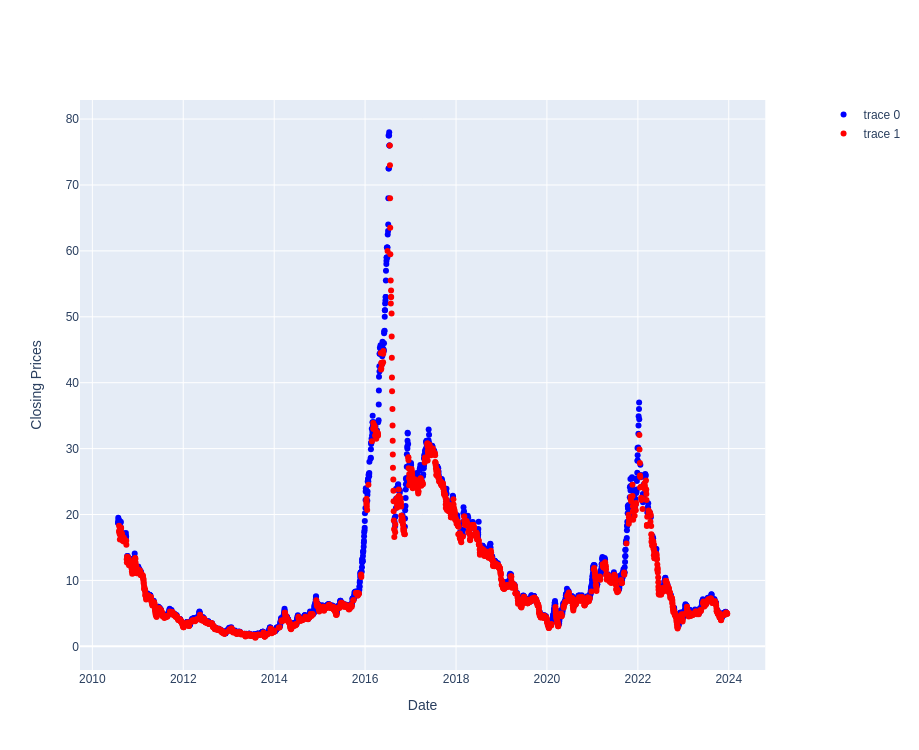

In [42]:
rc.plot_cluster(clustered_df)